# Team Introduction
Our group is comprised of Braden Anderson, Hien Lam, and Tavin Weeda. 

# Business Understanding
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.

Crash Report Sampling System (CRSS) is a probability sample of police-reported traffic crashes used to analyze crash trends and promote highway safety measures as well as public information initiatives. The 2020 data encompassing driver-related, vehicular accidents was obtained. First, we seek to predict injury severity of the crash. This is a classification technique in which effectiveness will be measured with accuracy, recall, F1 score, and ROC AUC in conjunction with 10-fold cross validation. Afterwards, we will conduct regression to predict age of driver and obtain its mean squared error, root mean squared error, and mean absolute percentage error in conjunction with 10-fold cross validation. Our goal is to elucidate factors that contribute to crashes as they relate to the driver, vehicle, road infrastructure, and environment in order to effectively reduce/prevent accidents.

# Data Meaning Type
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from dfply import *
from data_cleaning import *

In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/lam-hien/MSDS-Projects/main/Crash%20Severity%20Prediction/Data.csv')
df = pd.read_csv("./dataset_revs/Merged_File_05092022.csv")

In [3]:
# Function to clean the data
df = clean_data(dataframe=df)

In [4]:
# Select relevant columns for EDA where values are descriptive (not numerical indicators)
eda_df = df >> select(X.regionname, X.urbanicityname, X.makename, X.body_typname, X.mod_yearname, X.vtrafwayname, 
                      X.vnum_lanname, X.vsurcondname, X.vtrafconname, X.typ_intname, X.wrk_zonename, X.int_hwyname, 
                      X.weathername, X.wkdy_imname, X.hour_imname, X.reljct2_imname, X.lgtcon_imname, X.maxsev_imname, 
                      X.alchl_imname, X.age_im, X.sex_imname, X.vspd_lim, X.trav_sp, X.hour_binned, X.speeding_status)
# Remove "Area" from urban indicator value
eda_df["urbanicityname"] = eda_df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])
# Remove last 4 strings that indicate abbreviation of categorical level
eda_df['maxsev_imname'] = eda_df['maxsev_imname'].str[:-4]

In [5]:
print(eda_df.shape)
print(eda_df.info())

(48227, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 48227 entries, 0 to 48463
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   regionname       48227 non-null  object 
 1   urbanicityname   48227 non-null  object 
 2   makename         48227 non-null  object 
 3   body_typname     48227 non-null  object 
 4   mod_yearname     48227 non-null  object 
 5   vtrafwayname     48227 non-null  object 
 6   vnum_lanname     48227 non-null  object 
 7   vsurcondname     48227 non-null  object 
 8   vtrafconname     48227 non-null  object 
 9   typ_intname      48227 non-null  object 
 10  wrk_zonename     48227 non-null  object 
 11  int_hwyname      48227 non-null  object 
 12  weathername      48227 non-null  object 
 13  wkdy_imname      48227 non-null  object 
 14  hour_imname      48227 non-null  object 
 15  reljct2_imname   48227 non-null  object 
 16  lgtcon_imname    48227 non-null  object 
 17  

In [6]:
eda_df.head()

,regionname,urbanicityname,makename,body_typname,mod_yearname,vtrafwayname,vnum_lanname,vsurcondname,vtrafconname,typ_intname,...,reljct2_imname,lgtcon_imname,maxsev_imname,alchl_imname,age_im,sex_imname,vspd_lim,trav_sp,hour_binned,speeding_status
0,West,Rural,Toyota,"4-door sedan, hardtop",2018,"Two-Way, Not Divided",Five lanes,Snow,Traffic control signal(on colors) not known wh...,Four-Way Intersection,...,Intersection,Daylight,No Apparent In,No Alcohol Involved,61.0,Female,98,25,Morning,unknown
1,South,Urban,BMW,"4-door sedan, hardtop",2013,"Two-Way, Not Divided",Two lanes,Dry,No Controls,Not an Intersection,...,Non-Junction,Dark - Not Lighted,Possible In,No Alcohol Involved,23.0,Male,25,45,Night,speeding
2,West,Rural,Subaru,"Compact Utility (Utility Vehicle Categories ""S...",2015,"Two-Way, Divided, Positive Median Barrier",Two lanes,Snow,No Controls,Not an Intersection,...,Other location within Interchange Area,Daylight,No Apparent In,No Alcohol Involved,20.0,Male,80,65,Afternoon,not speeding
3,Northeast,Rural,Subaru,Station Wagon (excluding van and truck based),2004,Not Reported,Not Reported,Snow,Warning Sign,Not an Intersection,...,Non-Junction,Dark - Not Lighted,No Apparent In,No Alcohol Involved,23.0,Male,50,998,Evening,unknown
4,Midwest,Rural,Ford,Light Pickup,2003,Not Reported,Not Reported,Dry,No Controls,Not an Intersection,...,Non-Junction,Dark - Not Lighted,Possible In,No Alcohol Involved,57.0,Female,55,998,Evening,unknown


In [7]:
data = [
    ['regionname', 'categorical', 'where crash occurred', '4: Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT), West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI), Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS), South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)'],
    ['urbanicityname', 'categorical', 'geographical area of the crash', '2: urban (population >= 250k), rural (population < 250k)'],
    ['makename', 'categorical', 'manufacturer of vehicle', 'levels'],
    ['body_typname', 'categorical', 'vehicle classification based on its body configuration, size, shape, doors', 'levels'],
    ['mod_yearname', 'integer', 'vehicle model year', '-'],
    ['vtrafwayname', 'categorical', 'trafficway flow just prior to crash', 'levels'],
    ['vnum_lanname', 'categorical', 'number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts', 'levels'],
    ['vsurcondname', 'categorical', 'roadway surface condition just prior to crash', 'levels'],
    ['vtrafconname', 'categorical', 'traffic controls in the vehicle’s environment just prior to crash', 'levels'],
    ['typ_intname', 'categorical', 'type of intersection just prior to crash', 'levels'],
    ['wrk_zonename', 'categorical', 'whether crash occurred within boundaries of work zone', 'levels'],
    ['int_hwyname', 'categorical', 'whether crash occurred on interstate highway', 'levels'],
    ['weathername', 'categorical', 'prevailing atmospheric conditions at the time of the crash', 'levels'],
    ['wkdy_imname', 'categorical', 'day of week at time of the crash', 'levels'],
    ['hour_imname', 'categorical', 'hour at which crash occurred', '24'],
    ['hour_binned', 'categorical', 'hours binned', '4: morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night (midnight-6am)'],
    ['reljct2_imname', 'categorical', "crash's location with respect to presence in or proximity to junction or interchange areas", 'levels'],
    ['lgtcon_imname', 'categorical', 'type/level of light at time of crash', 'levels'],
    ['alchl_imname', 'categorical', "driver's alcohol use", 'levels'],
    ['age_im', 'integer', "driver's age at time of crash, in years, with respect to their last birthday", '-'],
    ['sex_imname', 'categorical', 'sex of driver', '2: male, female'],
    ['vspd_lim', 'integer', 'speed limit in mph', '-'],
    ['trav_sp', 'integer', 'speed of the vehicle prior to crash occurrence as reported by the officer', '-'],
    ['speeding_status', 'categorical', 'driver behavior relative to speed', '3: speeding, not speeding, unknown'],
    ['maxsev_imname', 'categorical', 'severity of injury sustained by the driver', '4: No apparent injury, possible injury, suspected serious injury, fatal injury']
]
datadesc = pd.DataFrame(data, columns=['Feature Name', 'Datatype', 'Description', 'Levels, if applicable'])
pd.set_option('max_colwidth',300)

print('This dataset consisted of 48227 rows and 25 columns. Relevant information for each attribute is as follows:')
datadesc

This dataset consisted of 48227 rows and 25 columns. Relevant information for each attribute is as follows:


,Feature Name,Datatype,Description,"Levels, if applicable"
0,regionname,categorical,where crash occurred,"4: Northeast (PA, NJ, NY, NH, VT, RI, MA, ME, CT), West (MT, ID, WA, OR, CA, NV, NM, AZ, UT, CO, WY, AK, HI), Midwest (OH, IN, IL, MI, WI, MN, ND, SD, NE, IA, MO, KS), South (MD, DE, DC, WV, VA, KY, TN, NC, SC, GA, FL, AL, MS, LA, AR, OK, TX)"
1,urbanicityname,categorical,geographical area of the crash,"2: urban (population >= 250k), rural (population < 250k)"
2,makename,categorical,manufacturer of vehicle,levels
3,body_typname,categorical,"vehicle classification based on its body configuration, size, shape, doors",levels
4,mod_yearname,integer,vehicle model year,-
5,vtrafwayname,categorical,trafficway flow just prior to crash,levels
6,vnum_lanname,categorical,number of travel lanes just prior to crash. Median: lanes in opposite directions are additive. No median: lanes in traveling direction counts,levels
7,vsurcondname,categorical,roadway surface condition just prior to crash,levels
8,vtrafconname,categorical,traffic controls in the vehicle’s environment just prior to crash,levels
9,typ_intname,categorical,type of intersection just prior to crash,levels


# Data Quality
Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.

Each observation corresponded to a driver from a unique accident, as noted under `casenum` thus duplicate data was a nonissue. Due to the reliance of information contained in police reports, missing values were present with the unreported or unknown designation. The most concerning features were `trav_sp` (traveling vehicle speed) and `vspd_lim` (reported speed limit). We simply plotted the raw values for EDA but will one-hot encode them going forward to keep the full data. The other features had very few unknown/unreported values (less than 1% of the data per variable) and were removed. Most of the outliers encountered were scant distributed among both extremes of categorical levels. We dealt with this by binning similar levels together to ensure the integrity of the data or removed them if they were not representative of our population. For example, age of cars 50+ were binned together and drivers below 16 years of age were removed.

In [8]:
# There are zero na values because the data will designate "unknown" or "unreported" instead.
na_vals = eda_df.isnull().sum()
na_vals[na_vals > 0]

Series([], dtype: int64)

In [9]:
# Verify that there are not any duplicate case numbers in the dataset.
df['casenum'].duplicated().sum()

0

# Simple Statistics
Visualize appropriate statistics (e.g., range, mode, mean, median, variance, counts) for a subset of attributes. Describe anything meaningful you found from this or if you found something potentially interesting. Note: You can also use data from other sources for comparison. Explain why the statistics run are meaningful.

In [10]:
# Descriptive statistics for the numeric attributes
eda_df.describe()

,age_im,vspd_lim,trav_sp
count,48227.000000,48227.000000,48227.000000
mean,39.630186,49.536712,577.973811
std,17.658778,24.601429,480.029421
min,5.000000,0.000000,0.000000
25%,25.000000,35.000000,35.000000
50%,36.000000,45.000000,998.000000
75%,53.000000,60.000000,998.000000
max,101.000000,99.000000,999.000000


In [11]:
# Descriptive statistics for the categorical attributes
eda_df.describe(include=[object], exclude=[np.number]).T

,count,unique,top,freq
regionname,48227,4,South,25379
urbanicityname,48227,2,Urban,35443
makename,48227,64,Ford,6424
body_typname,48227,56,"4-door sedan, hardtop",16844
mod_yearname,48227,67,2016,3660
vtrafwayname,48227,9,"Two-Way, Not Divided",20386
vnum_lanname,48227,10,Two lanes,17083
vsurcondname,48227,13,Dry,35982
vtrafconname,48227,19,No Controls,24395
typ_intname,48227,11,Not an Intersection,26721


# Visualize Attributes
Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

## Age of driver

The distribution of driver's age is right skewed with a peak at 20 years old.

In [12]:
# Data clean AGE: 
## Youngest driver is 5 years old and 180 obs where driver is below 16 years. Remove as those ages are clearly outliers or not representative of population
## Oldest driver is 101 and 984 obs where driver is 80+ years. Keep for EDA but will bin for modeling
print(f"Youngest driver: {eda_df['age_im'].min()} yrs, Number of drivers younger than 16 yrs: {len(eda_df >> mask(X.age_im < 16))}")
print(f"Oldest driver: {eda_df['age_im'].max()} yrs, Number of drivers 80+ yrs: {len(eda_df >> mask(X.age_im > 79))}")
age = eda_df >> filter_by(X.age_im >= 15)

Youngest driver: 5.0 yrs, Number of drivers younger than 16 yrs: 180
Oldest driver: 101.0 yrs, Number of drivers 80+ yrs: 984


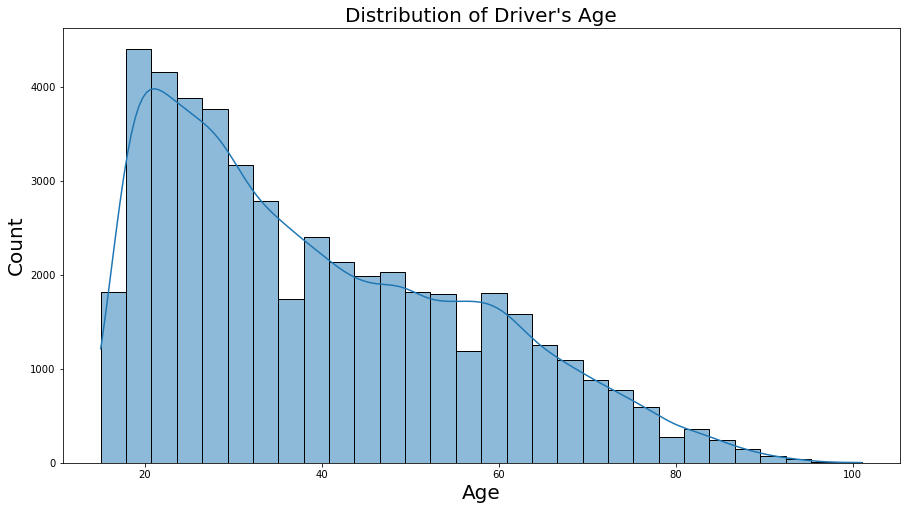

In [13]:
plt.figure(figsize = (15,8));
sns.histplot(age, x = "age_im", bins = 30, kde=True);
plt.xlabel('Age', size=20)
plt.ylabel('Count', size=20)
plt.title("Distribution of Driver's Age", size=20);

## Age of vehicle

## Driver's sex

## Lighting condition

## Traffic Way

## Time of Accident

## Reljct2 if time permits

# Explore Joint Attributes
Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

## Pairwise plot of continuous variables

## Sex vs. alcohol impairment

## Day of week vs. alcohol impairment

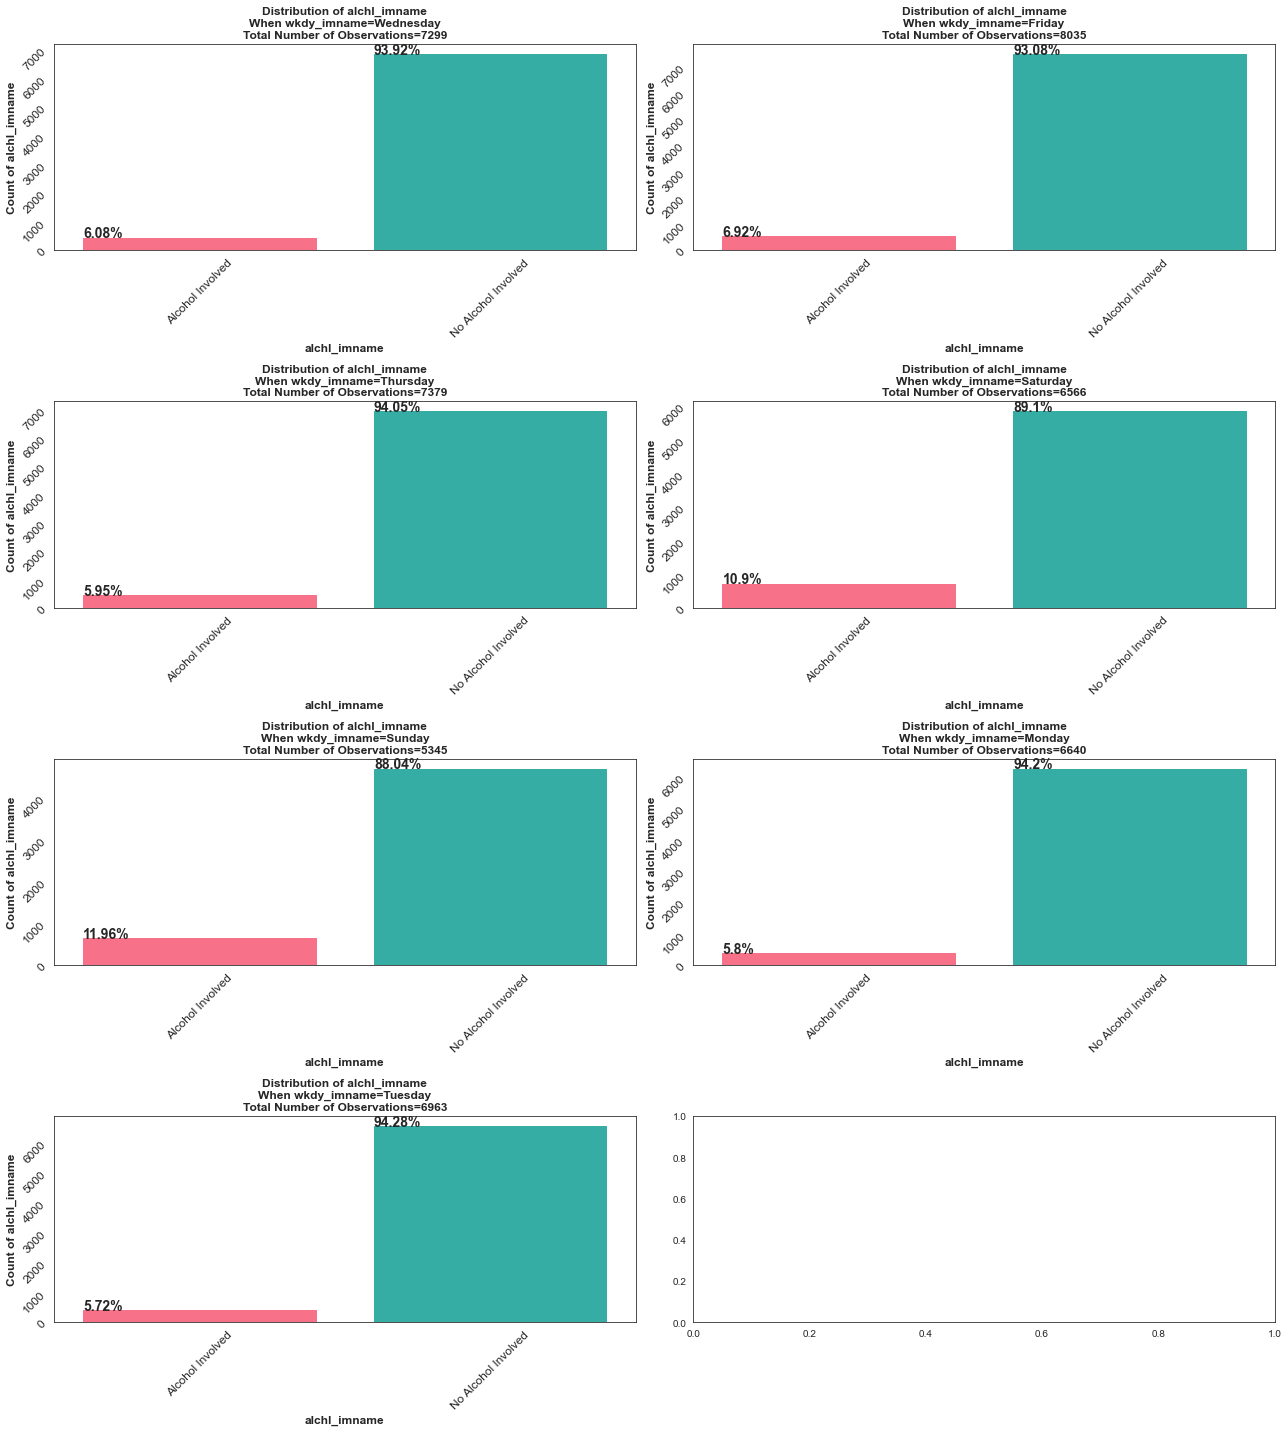

In [14]:
plot_feature_counts_by_grouping_level(dataframe=df, 
                                      plotting_column="alchl_imname", 
                                      grouping_column="wkdy_imname", 
                                      num_rows=4, 
                                      num_cols=2, 
                                      figsize=(18, 20), 
                                      title_fontsize=12,
                                      round_digits=2, 
                                      tick_rotation=45)

# This plot shows the distribution of alcohol related vs non-alcohol related crashes, broken down
# by the day of the week. Note that the total number of observations used in each subplot is available 
# in the plots title, and the percentage of observations in each level of the alcohol feature is annotated above the bar.
#
# Key Insight: For Monday-Thursday, only 5%-6% of all collisions involved an intoxicated driver. This percentage see's a 
# slight bump to nearly 7% on Friday, and then increases even further to 10.9% and 11.96% on Saturday and Sunday, respectively. 
# This insight aligns with our intuitions on human behavior, that on weekends people tend to break their normal routine 
# and may be more likely to engage in activities that involve alcohol consumption. 

## Age vs Time of Day

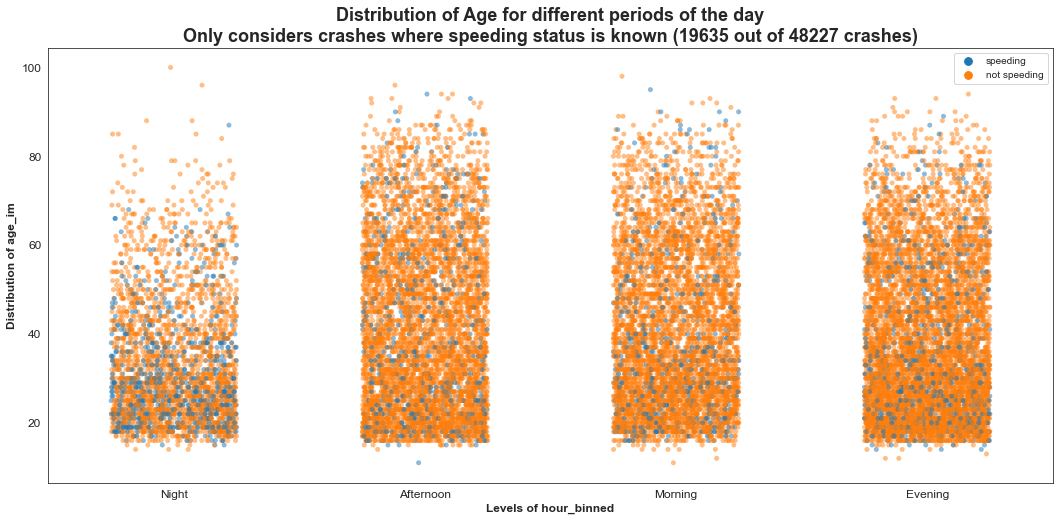

In [15]:
plot_title = ("Distribution of Age for different periods of the day\n"
              f"Only considers crashes where speeding status is known ({df.loc[df['speeding_status']!='unknown',:].shape[0]} out of {df.shape[0]} crashes)")

create_strip_plot(dataframe=df.loc[df["speeding_status"]!="unknown",:], 
                  categorical_feature="hour_binned", 
                  continuous_feature="age_im", 
                  shading_feature="speeding_status", 
                  title_fontsize=18,
                  title=plot_title,
                  jitter=0.25, 
                  alpha=0.5);


# Key Insight: 
#
# 1. The fact that the cluster of observations in the "Night" subgroup is noticably shorter than 
#    the cluster for any other period of the day is evidence that suggests drivers who get into collisions 
#    a night are less likely to be among the oldest members of the population.
#
# 2. The larger proportion of blue dots in the night subgroup, and the prominent cluster of blue near the
#    lower section of the night subgroup, indicate that collisions that occur at night are more likely 
#    to involve speeding, particularly when the driver is approximately 30 years old or younger. 

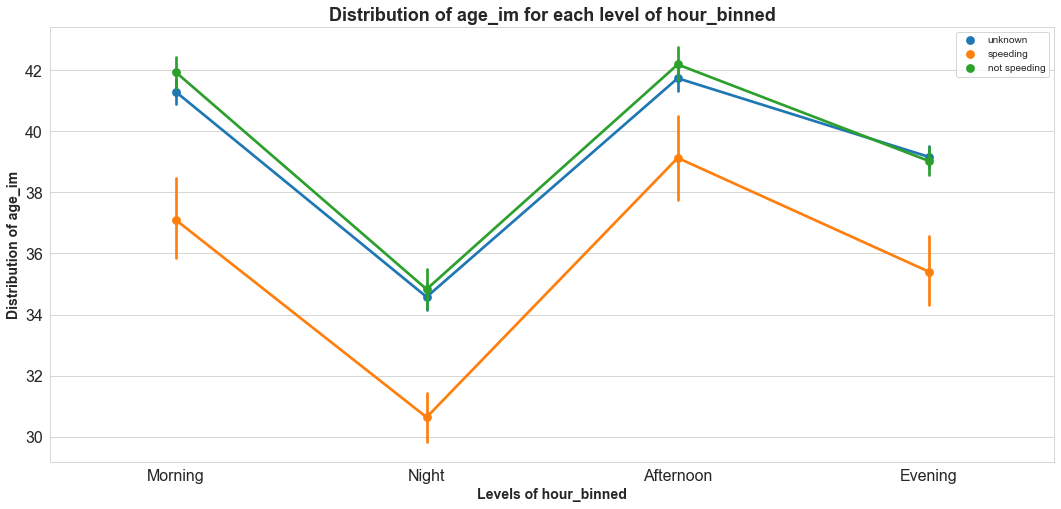

In [16]:
create_point_plot(dataframe=df, 
                  categorical_feature="hour_binned", 
                  continuous_feature="age_im", 
                  shading_feature="speeding_status");

# Key Insight: 
#
# This plot helps us start to quantify some of the intuitions we gained by viewing the plot above.
#
# 1. Our best estimate for the mean age of drivers who are involved in a night time 
#    collision while speeding is approximately 31 years old. Our best estimate for the
#    age of a driver who is involved in a night time collision while they were not
#    speeding is approximately 35 years old. 
#
# 2. For all periods of the day, the average age of a driver who is involved in a speeding
#    collisions is significantly less than a driver who is involved in a non-speeding related 
#    collision. Additionally, the estimated difference in mean ages appears to be relatively
#    consistent across the periods of the day. 

## Relationship 5

# Explore Attributes and Class
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

## Severity vs. Gender and Alcohol Impairment

## Severity vs. Time of Day

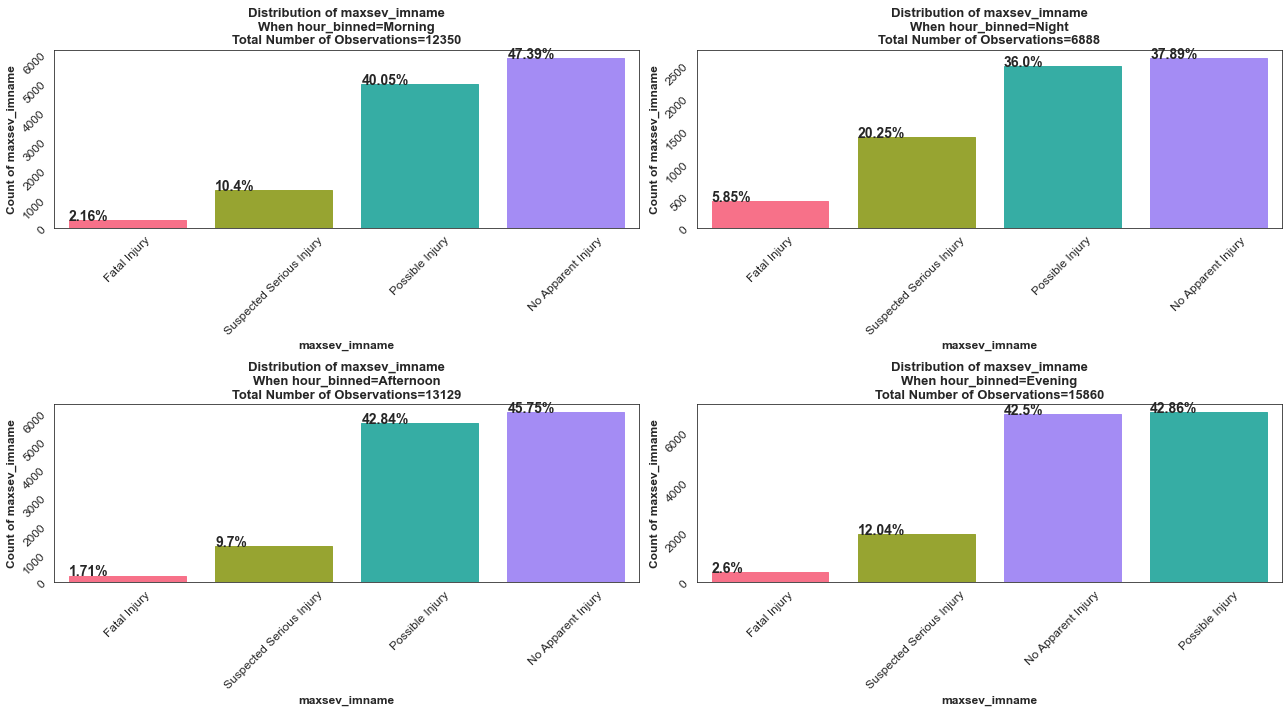

In [17]:
plot_feature_counts_by_grouping_level(dataframe=df, 
                                      plotting_column="maxsev_imname", 
                                      grouping_column="hour_binned", 
                                      num_rows=2, 
                                      num_cols=2, 
                                      figsize=(18, 10), 
                                      title_fontsize=13,
                                      round_digits=2)

# This plot shows the distribution of accident severity, and is broken down 
# by which period of the day the accident occured during (Morning, Afternoon, Evening, or Night).
#
# Key Insight: We see that the percentage of accidents that result in fatality is noticably higher
#              for collisions that occur at night, vs any other period of the day. This result is intuitive 
#              because there are a number of factors we believe to be more common at night that contribute to
#              making a collision more severe. These factors include:
#              1. Increased Alcohol consumption at night
#              2. Increased driver fatigue at night
#              3. Decreased visibility at night

## Severity vs. Age of Driver

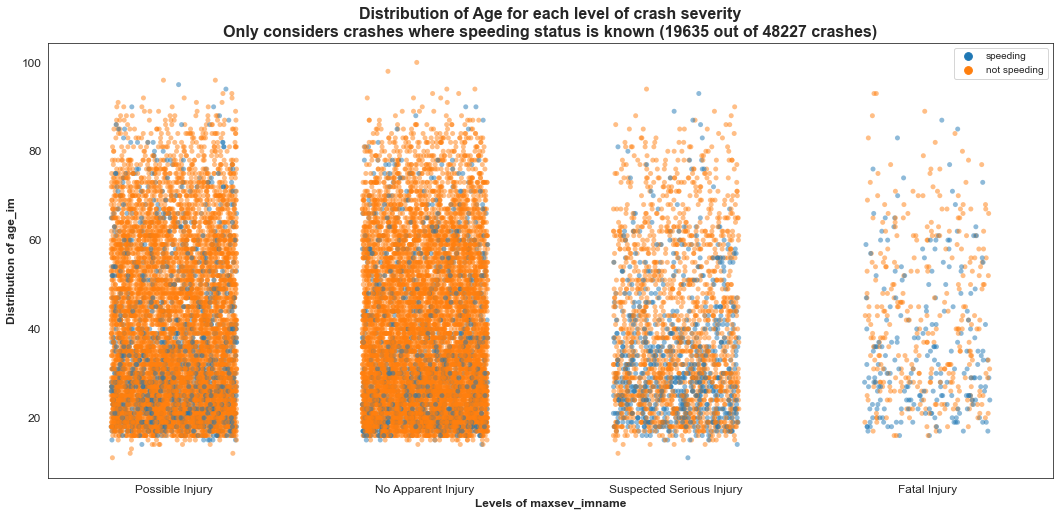

In [18]:
plot_title = ("Distribution of Age for each level of crash severity\n"
              f"Only considers crashes where speeding status is known ({df.loc[df['speeding_status']!='unknown',:].shape[0]} out of {df.shape[0]} crashes)")

create_strip_plot(dataframe=df.loc[df["speeding_status"]!="unknown",:], 
                  categorical_feature="maxsev_imname", 
                  continuous_feature="age_im", 
                  shading_feature="speeding_status", 
                  title=plot_title,
                  jitter=0.25, 
                  alpha=0.5);

# Key Insights:
#
# 1. For the lower severity crashes (left half of plot), the blue gets drowned out by the orange, which
#    shows that there are many more non-speeding related collisions than ones that did involve speeding.
# 
# 2. For the higher severity crashes (right half of plot), we start seeing a lot more blue coming through, 
#    indicating that speeding may be a larger factor in high severity collisions. This insight aligns with our 
#    intuition that at increased speeds a collision is likely to be more dangerous. 
# 
# 3. Notice the larger clusters of blue on the lower half, indicating that younger drivers seem to speed more.
#    This also aligns with general intuition about human behavior and maturity/responsibility to follow traffic laws.
#
#    Need to acknowledge that in most cases, speeding is actually "unknown". Those points have been removed for this chart, but
#    if they are included, everything gets drowned out by the "unknown" speeding observations.

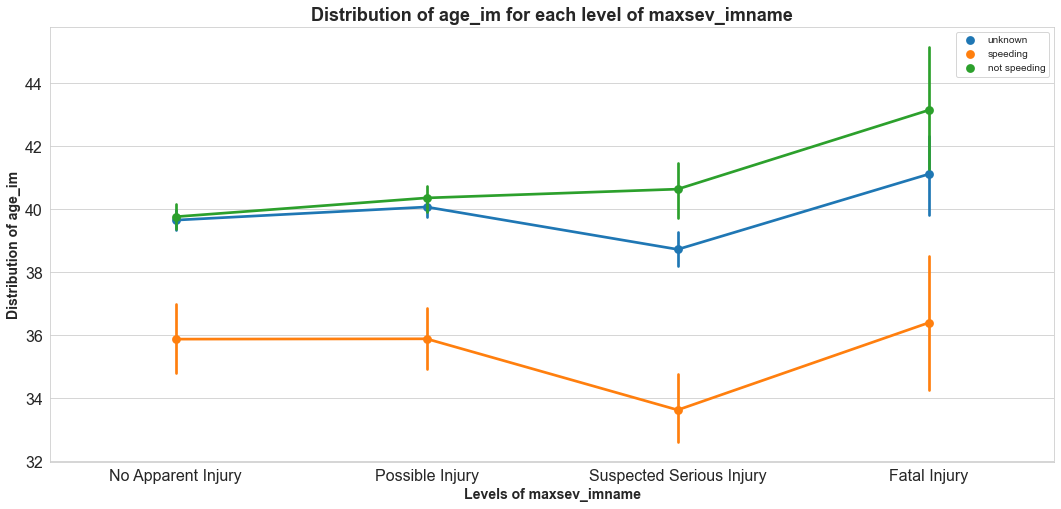

In [19]:
create_point_plot(dataframe=df, 
                  categorical_feature="maxsev_imname", 
                  continuous_feature="age_im", 
                  shading_feature="speeding_status");


# Key Insights:
# 
# This chart offers another (and perhaps more clear) perspective on similiar information that was
# conveyed in the strip plot above. This chart also conveys some additional information by including the 
# crashes where speeding_status was unknown (either due to unknown vehicle speed, unknown speed limit, or both).
#
# 1. From the distance between the orange and green lines, we see that the average age of drivers who were involved 
#    in a collision while speeding is approximately 4 years younger than the average age of drivers who got into
#    a collision and were not speeding. This difference appears to be relatively constant across all levels of 
#    accident severity.
#
# 2. The fact that the collisions where speeding_status was unknown (blue line) falls in between the green and
#    orange lines makes sense. This is an intuitive result because, in reality, all drivers were either speeding or
#    they were not (although in some cases we do not know which). This means it would be reasonable to expect the 
#    blue line to be some weighted average of the green and orange lines, which is a possible interpretation of 
#    what is shown here.

## Severity vs. Area

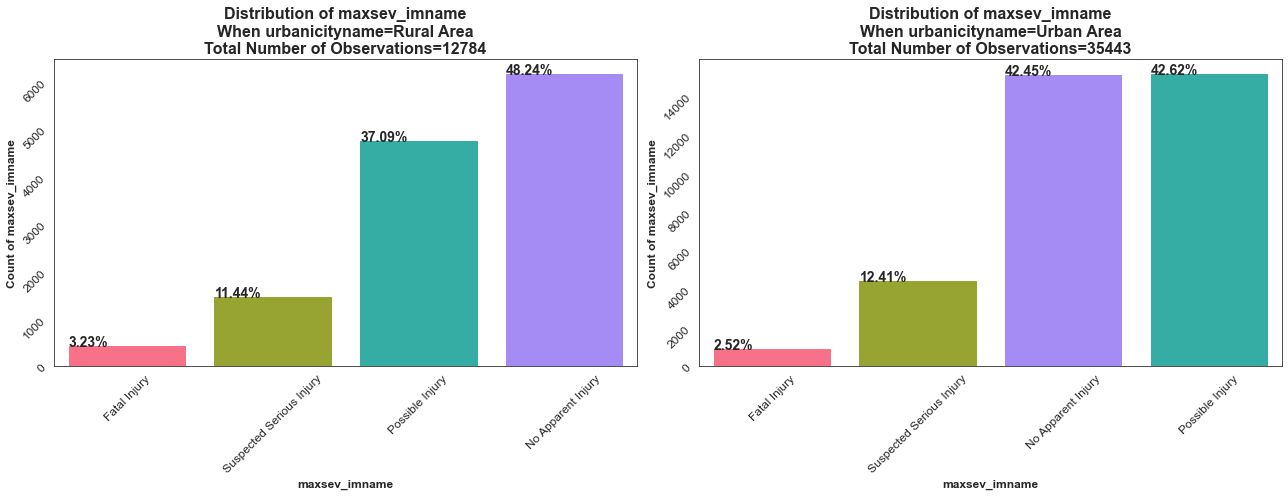

In [20]:
plot_feature_counts_by_grouping_level(dataframe=df, 
                                      plotting_column="maxsev_imname", 
                                      grouping_column="urbanicityname", 
                                      num_rows=1, 
                                      num_cols=2, 
                                      figsize=(18, 7), 
                                      title_fontsize=16,
                                      round_digits=2)

# Key Insights:
# 
# 1. As shown in the title of the plots, this is a nice visual reminder that our dataset includes
#    nearly 3 times as many collisions from urban areas as compared to rural. The Crash Report 
#    Sampling System Analytics manual associated with this dataset describes in detail the careful 
#    sampling techniques that were used when collecting this collision dataset. This is an interesting 
#    point because their it lends some credibility to the idea that this 3x discrepancy may reflect
#    the underlying distribution of all collisions. 
#
# 2. Although the difference is relatively minor, it is worth noting that the most common
#    accident severity in rural areas is no apparent injury, while for urban areas, the most
#    common is possible injury. It will be interesting to see if these subtle differences are 
#    enough for our machine learning algorithms to pick up on, and utilize towards effectively 
#    separating the classes.

# New Features
Are there other features that could be added to the data or created from existing features? Which ones?

1. Did we change year of vehicle to age?
2. Incorporated new feature `hour_binned` that encompassed time of accident into four levels: morning, afternoon, evening, night
3. Incorporated new feature `speeding_status` that noted if driver went over the speed limit, under the limit, or speed unknown
4. Should expand `speeding_status` feature with actual values e.g., +5 or -5 for 5 mph over/under, respectively
5. Potentially useful feature: historical proportion of car make or model that have propensity of being in accidents 
6. Potentially useful feature: lane size as research has shown increasing lane size is associated with a decrease in accident rates
7. Potentially useful feature: vehicle role e.g., presence of 18 wheelers is associated with an increase in accident but this rate decreases when they are allowed their own lane

# Exceptional Work
You have free reign to provide additional analyses. One idea: implement dimensionality reduction, then visualize and interpret the results.

In [21]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import column, row
from bokeh.models import (BasicTicker, ColorBar, ColumnDataSource, HoverTool, Select, CustomJS, Title,
                          LinearColorMapper, PrintfTickFormatter)
from bokeh.palettes import mpl
from bokeh.transform import transform

In [22]:
def create_group_percentages_df(df, group_feature, subgroup_feature, agg_column_name):
    
    dataframe = pd.DataFrame(df.groupby(by=[group_feature])[subgroup_feature].value_counts(normalize=True)).rename(columns={subgroup_feature:agg_column_name})
    
    return dataframe


def create_aggregate_df(df, categorical_feature1, categorical_feature2, continuous_feature, cat_feat1_name, 
                        cat_feat2_name, continuous_feat_name, aggregate_functions=['mean', 'median', 'count'], 
                        include_zero_observation_categories=True):
    
    pct_column1_name = f"pct_of_{cat_feat1_name}_class"
    pct_column2_name= f"pct_of_{cat_feat2_name}_class"
    
    pct_df1 = create_group_percentages_df(df=df,
                                          group_feature=categorical_feature1, 
                                          subgroup_feature=categorical_feature2, 
                                          agg_column_name=pct_column1_name)
    
    # Turn decimal percentage (between 0 and 1) into percentage between 0 and 100
    pct_df1[pct_column1_name] = pct_df1[pct_column1_name] * 100
    
    pct_df2 = create_group_percentages_df(df=df,
                                          group_feature=categorical_feature2, 
                                          subgroup_feature=categorical_feature1, 
                                          agg_column_name=pct_column2_name).swaplevel()
    
    # Turn decimal percentage (between 0 and 1) into percentage between 0 and 100
    pct_df2[pct_column2_name] = pct_df2[pct_column2_name] * 100
    
    
    agg_functions = [(f"{func}_age", func) if func != 'count' else (f"total_observations", func) for func in aggregate_functions]
    agg_df = df.groupby(by=[categorical_feature1, categorical_feature2])[continuous_feature].agg(agg_functions)
    
    pct_df1 = pct_df1.join(other=pct_df2, on=[categorical_feature1, categorical_feature2])
    agg_df = agg_df.join(other=pct_df1, on=[categorical_feature1, categorical_feature2])
    
    agg_df = agg_df.reset_index()
    
    if include_zero_observation_categories:
        list1 = agg_df[categorical_feature1].tolist()
        list2 = agg_df[categorical_feature2].tolist()
        
        unique1 = df[categorical_feature1].unique().tolist()
        unique2 = df[categorical_feature2].unique().tolist()
        unique_combos = [(one, two) for one in unique1 for two in unique2]
        present_combos = [(one, two) for one, two in zip(list1, list2)]
        missing_combos = [combo for combo in unique_combos if combo not in present_combos]
        
        categorical_columns = [categorical_feature1, categorical_feature2]
        zero_columns = [column for column in agg_df.columns if column not in categorical_columns]
        zero_dict = {column:[0 for _ in range(len(missing_combos))] for column in zero_columns}
        
        zero_dict[categorical_feature1] = [feat1 for feat1, feat2 in missing_combos]
        zero_dict[categorical_feature2] = [feat2 for feat1, feat2 in missing_combos]
        zero_df = pd.DataFrame(zero_dict)
        
        agg_df = pd.concat(objs=[agg_df, zero_df], axis='index').sort_values(by=categorical_feature1)
        
    return agg_df

In [23]:
example_ag_df = create_aggregate_df(df=df,
                            categorical_feature1="maxsev_imname", 
                            categorical_feature2="alchl_imname", 
                            continuous_feature="age_im", 
                            cat_feat1_name="severity", 
                            cat_feat2_name="alch", 
                            continuous_feat_name="age", 
                            include_zero_observation_categories=True)

example_ag_df

,maxsev_imname,alchl_imname,mean_age,median_age,total_observations,pct_of_severity_class,pct_of_alch_class
0,Fatal Injury,Alcohol Involved,38.011561,33.0,346.0,26.493109,9.672910
1,Fatal Injury,No Alcohol Involved,41.886458,38.0,960.0,73.506891,2.150056
2,No Apparent Injury,Alcohol Involved,37.932099,35.0,972.0,4.582528,27.173609
3,No Apparent Injury,No Alcohol Involved,39.612975,36.0,20239.0,95.417472,45.328108
4,Possible Injury,Alcohol Involved,38.430389,35.0,1336.0,6.731157,37.349734
5,Possible Injury,No Alcohol Involved,40.042567,36.0,18512.0,93.268843,41.460246
6,Suspected Serious Injury,Alcohol Involved,36.228602,33.0,923.0,15.745479,25.803746
7,Suspected Serious Injury,No Alcohol Involved,39.124317,35.0,4939.0,84.254521,11.061590


In [24]:
def get_plot_info(categorical_feature1, categorical_feature2, cat_feat1_name, cat_feat2_name, shade_categorical1_pct):
    
    plot_info = {}
    
    if shade_categorical1_pct:
        shade_column = f"pct_of_{cat_feat1_name}_class"
        shade_column_option2 = f"pct_of_{cat_feat2_name}_class"
        
        plot_info["shade_column"] = shade_column
        plot_info["shade_column_option2"] = shade_column_option2
        
        plot_info["MAIN_TITLE"] = f"Heatmap showing percentage breakdown of {categorical_feature2} within each level of {categorical_feature1} (shading by column percent)"
        plot_info["SUBTITLE"] = f"{shade_column}=column percent,   {shade_column_option2}=row percent"
        
        plot_info["MAIN_TITLE_OPTION2"] = f"Heatmap showing percentage breakdown of {categorical_feature1} within each level of {categorical_feature2} (shading by row percent)"
        plot_info["SUBTITLE_OPTION2"] = f"{shade_column_option2}=row percent,   {shade_column}=column percent"
    else:
        shade_column = f"pct_of_{cat_feat2_name}_class"
        shade_column_option2 = f"pct_of_{cat_feat1_name}_class"
        
        plot_info["shade_column"] = shade_column
        plot_info["shade_column_option2"] = shade_column_option2
        
        plot_info["MAIN_TITLE"] = f"Heatmap showing percentage breakdown of {categorical_feature1} within each level of {categorical_feature2} (shading by row percent)"
        plot_info["SUBTITLE"] = f"{shade_column}=row percent,   {shade_column_option2}=column percent"
        
        plot_info["MAIN_TITLE_OPTION2"] = f"Heatmap showing percentage breakdown of {categorical_feature2} within each level of {categorical_feature1} (shading by column percent)"
        plot_info["SUBTITLE_OPTION2"] = f"{shade_column_option2}=column percent,   {shade_column}=row percent"
        
        
    return plot_info

def get_all_plot_infos(categorical_feature1, categorical_feature2, cat_feat1_name, cat_feat2_name, shade_categorical1_pct):
    
    p_info = {cat_feature2:get_plot_info(categorical_feature1=categorical_feature1, 
                                         categorical_feature2=cat_feature2, 
                                         cat_feat1_name=cat_feat1_name, 
                                         cat_feat2_name=cat_feature2_name, 
                                         shade_categorical1_pct=shade_categorical1_pct) for cat_feature2, cat_feature2_name in zip(categorical_feature2, 
                                                                                                                                   cat_feat2_name)}
    
    
    return p_info


def get_all_aggregate_dfs(df, categorical_feature1, categorical_feature2, continuous_feature, cat_feat1_name, 
                        cat_feat2_name, continuous_feat_name, aggregate_functions=['mean', 'median', 'count']):
    
    agg_data = {cat_feature2:create_aggregate_df(df=df,
                                                 categorical_feature1=categorical_feature1, 
                                       categorical_feature2=cat_feature2, 
                                       continuous_feature=continuous_feature, 
                                       cat_feat1_name=cat_feat1_name, 
                                       cat_feat2_name=cat_feature2_name, 
                                       continuous_feat_name=continuous_feat_name) for cat_feature2, cat_feature2_name in zip(categorical_feature2, 
                                                                                                                                   cat_feat2_name)}
    

    
    return agg_data


def get_all_tool_tips(agg_dataframes, categorical_feature1):
    
    tools = {}
    
    for feature, ag_df in agg_dataframes.items():
        
        axes_columns = [categorical_feature1, feature]
        
        # List the columns that contain data we want to main availble to the hover tool
        tools[feature] = [(f"{column_name}", f"@{column_name}") for column_name in ag_df.columns 
                          if column_name not in axes_columns]

    return tools

In [38]:
def create_bokeh_heatmap(dataframe, categorical_feature1="maxsev_imname", 
                         categorical_feature2=["speeding_status", "sex_imname", "weathername", "alchl_imname", "wkdy_imname", "hour_binned", "lgtcon_imname"], 
                         cat_feat2_name=["speeding", "sex","weather","alcohol", "weekday", "hour", "light"],
                         aggregate_functions=['mean', 'median', 'count'], colors=None, palette_name="Plasma", palette_num=11,
                         continuous_feature="age_im", cat_feat1_name="severity", continuous_feat_name="age", fig_width=1200, fig_height=500, 
                         shade_categorical1_pct=True, tools="hover", x_axis_location="above", color_bar_tick_format="%.2f%%", 
                         color_bar_location='right', subtitle_font_style="italic", title_font_size="12pt"):
    
    
    start_cat2 = categorical_feature2[0]
    start_cat2_name = cat_feat2_name[0]
    
    # Plot labels need to be update when:
    # 1) The column used to shade the heatmap changes
    # 2) The column used on the heatmap vertical axis changes.
    # p_infos contains all the title and subtitle options associated with the 
    # available menu choices. These are used to update the plot title in 
    # the javascript callback. 
    p_infos = get_all_plot_infos(categorical_feature1=categorical_feature1, 
                                 categorical_feature2=categorical_feature2, 
                                 cat_feat1_name=cat_feat1_name, 
                                 cat_feat2_name=cat_feat2_name, 
                                 shade_categorical1_pct=shade_categorical1_pct)
        
    # Calculate the aggregation statistics. This is the information Bokeh will use to both
    # color the heatmap, and present additional statistics via the hover tool
    agg_dfs =  get_all_aggregate_dfs(df=dataframe,
                                     categorical_feature1=categorical_feature1, 
                                     categorical_feature2=categorical_feature2, 
                                     continuous_feature=continuous_feature, 
                                     cat_feat1_name=cat_feat1_name, 
                                     cat_feat2_name=cat_feat2_name, 
                                     continuous_feat_name=continuous_feat_name, 
                                     aggregate_functions=aggregate_functions)
    
    # When we update the column name, we want the hover tool to get more information, which means
    # we need a new set of tooltips. This creates the required tool tips for all menu options.
    all_tool_tips = get_all_tool_tips(agg_dataframes=agg_dfs, categorical_feature1=categorical_feature1)
    
    # Initial hover-tool information and initial dataframe.
    tool_tip_list = all_tool_tips[start_cat2]
    aggregate_df = agg_dfs[start_cat2]

    # Output in the jupyter notebook
    output_notebook()
    
    # Set the color palette, either a list passed by the user,
    # or default to bokehs version of matplotlib Plasma 11.
    if colors is None:
        colors = mpl[palette_name][palette_num]
    
    # Color mapper shading based on percentages 
    mapper = LinearColorMapper(palette=colors, low=aggregate_df[p_infos[start_cat2]['shade_column']].min(), 
                               high=aggregate_df[p_infos[start_cat2]['shade_column']].max())
    
    
    # Set up the figure
    p = figure(width=fig_width, 
               height=fig_height, 
               x_range=aggregate_df[categorical_feature1].unique().tolist(), 
               y_range=aggregate_df[start_cat2].unique().tolist(),
               toolbar_location=None, 
               x_axis_location=x_axis_location)
    
    # Instantiate title and subtitle objects, and add to chart
    subtitle_renderer = Title(text=p_infos[start_cat2]["SUBTITLE"], text_font_style=subtitle_font_style)
    title_renderer = Title(text=p_infos[start_cat2]["MAIN_TITLE"],  text_font_size=title_font_size)
    p.add_layout(subtitle_renderer, place='above')
    p.add_layout(title_renderer, place='above')
    
    # Set up the data source
    source = ColumnDataSource(aggregate_df)
    agg_dfs = {key:value.to_dict(orient='list') for key, value in agg_dfs.items()}
    
    # Color in the squares
    renderer  = p.rect(x=categorical_feature1, 
                       y=start_cat2, 
                       width=1, 
                       height=1, 
                       source=source,
                       fill_color={'field': p_infos[start_cat2]["shade_column"], 'transform': mapper})
    
    # Instantiate Hover Tool and add to chart
    hover_tool = HoverTool(renderers=[renderer], tooltips=tool_tip_list)
    p.add_tools(hover_tool)
                                
    # Create a color bar
    color_bar = ColorBar(color_mapper=mapper,
                         ticker=BasicTicker(desired_num_ticks=len(colors)),
                         formatter=PrintfTickFormatter(format=color_bar_tick_format))
    
    # Put the color bar on the right hand side
    p.add_layout(color_bar, color_bar_location)
    
    # Axis Settings
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "8pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    
    # Set up the drop down ticker
    DEFAULT_TICKERS = [p_infos[start_cat2]["shade_column"], p_infos[start_cat2]["shade_column_option2"]]
    ticker = Select(value=p_infos[start_cat2]["shade_column"], options=DEFAULT_TICKERS)
    
    column_choices = categorical_feature2
    column_ticker = Select(value=start_cat2, options=column_choices)

    # Write the javascript callback that gets triggered when the dropdown menu changes
    # This callback will update the plot title and plot shading based on what is selected in the drop down.
    ticker_change = CustomJS(args = dict(renderer = renderer, 
                                         p = p, 
                                         subtitle_renderer=subtitle_renderer, 
                                         title_renderer=title_renderer,
                                         p_titles=p_infos),
                             code="""
    
    const title_key = current_column.value;
    
    const active = cb_obj.value;
    
    const data = renderer.data_source.data[active];
    const {transform} = renderer.glyph.fill_color;
    transform.low = Math.min(...data);
    transform.high = Math.max(...data);
    renderer.glyph.fill_color = {field: cb_obj.value, transform: transform};
    
    
    const subkey = "SUBTITLE";
    const subkey2 = "SUBTITLE_OPTION2";
    const mainkey = "MAIN_TITLE";
    const mainkey2 = "MAIN_TITLE_OPTION2";
    const shadekey = "shade_column";
    
    const subtitle = p_titles[title_key][subkey];
    const maintitle = p_titles[title_key][mainkey];
    const maintitle_option2 = p_titles[title_key][mainkey2];
    const subtitle_option2 = p_titles[title_key][subkey2];
    const shade_option1 = p_titles[title_key][shadekey];
    
    if(active === shade_option1){
        subtitle_renderer.text = subtitle;
        title_renderer.text= maintitle;
    }else{
        title_renderer.text = maintitle_option2;
        subtitle_renderer.text = subtitle_option2;
    }
    
    p.reset.emit()
                                          """)
    
        # Write the javascript callback that gets triggered when the dropdown menu changes
    # This callback will update the plot title and plot shading based on what is selected in the drop down.
    column_ticker_change = CustomJS(args = dict(renderer = renderer, 
                                                p = p, 
                                                subtitle_renderer=subtitle_renderer, 
                                                title_renderer=title_renderer, 
                                                all_datasets=agg_dfs,
                                                source=source, 
                                                hover_tool=hover_tool,
                                                all_tool_tips=all_tool_tips,
                                                p_titles=p_infos),
                             code="""
    
    
    const subkey = "SUBTITLE";
    const subkey2 = "SUBTITLE_OPTION2";
    const mainkey = "MAIN_TITLE";
    const mainkey2 = "MAIN_TITLE_OPTION2";
    const shadekey = "shade_column";
    const shadekey2 = "shade_column_option2";
        
    const current_shade_column = current_shade.value;
    const new_column_name = cb_obj.value;
    
    const subtitle = p_titles[new_column_name][subkey];
    const maintitle = p_titles[new_column_name][mainkey];
    const maintitle_option2 = p_titles[new_column_name][mainkey2];
    const subtitle_option2 = p_titles[new_column_name][subkey2];
    
    const new_shade_column = p_titles[new_column_name][shadekey];
    const new_shade_option2 = p_titles[new_column_name][shadekey2];
    const new_shade_options = [new_shade_column, new_shade_option2];
    
    current_shade.value = new_shade_column;
    current_shade.options = new_shade_options;
    
    subtitle_renderer.text = subtitle;
    title_renderer.text= maintitle;
    
    hover_tool.tooltips = all_tool_tips[new_column_name];
    const new_data = all_datasets[new_column_name];
    
    renderer.glyph.y.field=new_column_name;
    renderer.data_source.data['y'] = new_data[new_column_name];
    renderer.data_source.data = new_data;

    const data = renderer.data_source.data[new_shade_column];
    const new_labels = [...new Set(renderer.data_source.data[new_column_name])];

    p.y_range.factors = new_labels;
    p.y_range.end = new_labels.length;
    
    const {transform} = renderer.glyph.fill_color;
    transform.low = Math.min(...data);
    transform.high = Math.max(...data);
    renderer.glyph.fill_color = {field: new_shade_column, transform: transform};
    
    p.reset.emit()
                                          """)
    
    
    # Set up ticker callbacks
    ticker.js_on_change('value', ticker_change)
    column_ticker.js_on_change('value', column_ticker_change)
    
    # Let the ticker callbacks talk to eachother
    ticker_change.args["current_column"] = column_ticker
    column_ticker_change.args["current_shade"] = ticker
    
    # Row of tickers
    ticker_row = row(children=[ticker, column_ticker])
    
    # Put the plot and both tickers in a layout
    layout = column(children=[ticker_row, p], sizing_mode="scale_width")
    
    #return show(p)
    return show(layout)

In [39]:
create_bokeh_heatmap(dataframe=df)

Loading BokehJS ...

# References
Data dictionary referenced from CRSS Analytical Users Manual (include link here)